<a href="https://colab.research.google.com/github/Naveenbsm/Deep-Learning-Applications-in-Retinal-Disease-Detection/blob/main/Deep_Learning_Applications_in_Retinal_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Necessary Libraries

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_dir = '/content/drive/MyDrive/eyedisease'
folders = os.listdir(file_dir)
file_path =[]
labels = []
for folder in folders:
    sub_folder = os.path.join(file_dir, folder)
    filelist = os.listdir(sub_folder)
    for file in filelist:
        f_path = os.path.join(sub_folder, file)
        file_path.append(f_path)
        labels.append(folder)
df =pd.DataFrame({"filepath": file_path, "label":labels})
df.head()

,filepath,label
0,/content/drive/MyDrive/eyedisease/glaucoma/_43...,glaucoma
1,/content/drive/MyDrive/eyedisease/glaucoma/127...,glaucoma
2,/content/drive/MyDrive/eyedisease/glaucoma/197...,glaucoma
3,/content/drive/MyDrive/eyedisease/glaucoma/_11...,glaucoma
4,/content/drive/MyDrive/eyedisease/glaucoma/149...,glaucoma


In [6]:
def load_dataset(file_dir):
    """
    Load file paths and labels from the dataset directory

    Args:
        file_dir (str): Path to the dataset directory

    Returns:
        pd.DataFrame: DataFrame with file paths and labels
    """
    file_paths = []
    labels = []

    folders = os.listdir(file_dir)
    for folder in folders:
        sub_folder = os.path.join(file_dir, folder)
        filelist = os.listdir(sub_folder)

        for file in filelist:
            f_path = os.path.join(sub_folder, file)
            file_paths.append(f_path)
            labels.append(folder)

    return pd.DataFrame({"filepath": file_paths, "label": labels})
df = load_dataset(file_dir)

In [7]:
df.shape

(4217, 2)

## Exploratory Data Analysis

<Axes: xlabel='label'>

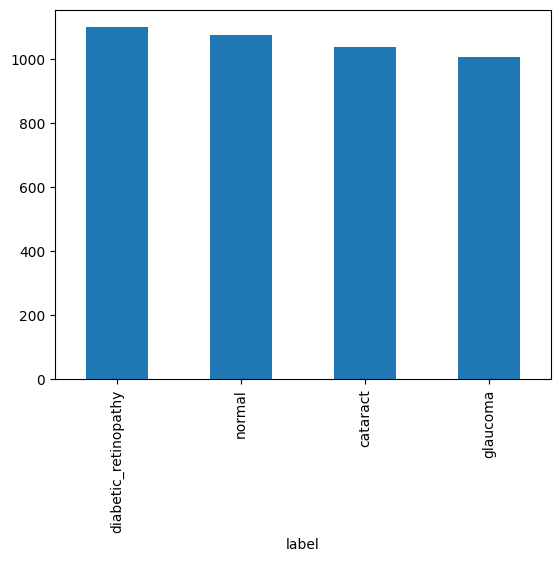

In [8]:
df['label'].value_counts().plot(kind='bar')

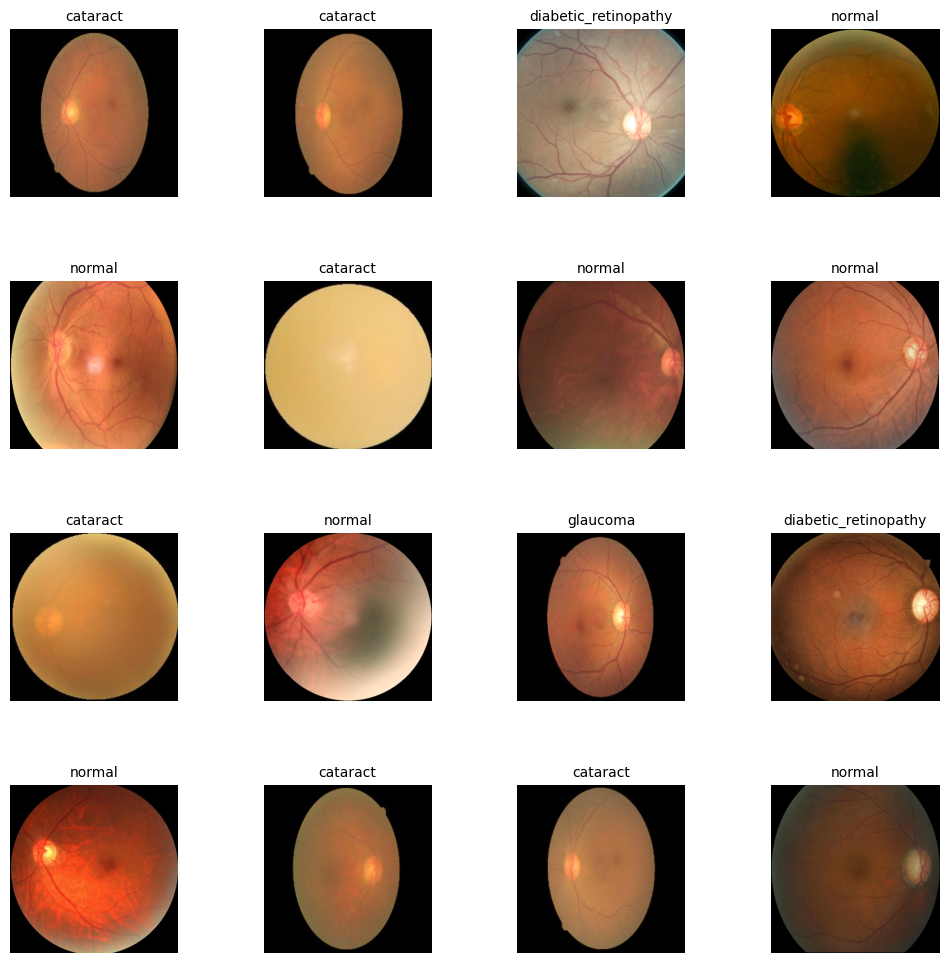

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly sample 16 images from the dataset
sampled_images = df.sample(16).reset_index()

# Set up the grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop through the grid and plot each image
for i, ax in enumerate(axes.flat):
    img_path = sampled_images['filepath'][i]
    label = sampled_images['label'][i]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis('off')  # Hide axis for better visualization

plt.show()


In [10]:
def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess single image with enhancement techniques

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output image size

    Returns:
        np.ndarray: Preprocessed image
    """
    try:
        # Read image with error handling
        image = cv2.imread(image_path)

        # Check if image is loaded successfully
        if image is None:
            print(f"Warning: Unable to read image {image_path}")
            return None

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize with aspect ratio preservation
        h, w = image.shape[:2]
        aspect_ratio = w / h

        # Resize maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(new_w / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(new_h * aspect_ratio)

        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Create blank canvas
        canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

        # Calculate positioning to center the image
        y_start = (target_size[1] - new_h) // 2
        x_start = (target_size[0] - new_w) // 2

        # Place resized image on canvas
        canvas[y_start:y_start+new_h, x_start:x_start+new_w] = resized

        # Convert to float and normalize
        normalized = canvas.astype(np.float32) / 255.0

        return normalized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

## Data Preprocessing

In [11]:

def prepare_dataset(file_dir, test_size=0.2, random_state=42):
    """
    Prepare and preprocess the entire dataset

    Args:
        file_dir (str): Path to the dataset directory
        test_size (float): Proportion of dataset for testing
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: Preprocessed and split dataset
    """
    # Load dataset
    df = load_dataset(file_dir)

    # Preprocess images with error handling
    processed_images = []
    processed_labels = []

    for path, label in zip(df['filepath'], df['label']):
        img = preprocess_image(path)
        if img is not None:
            processed_images.append(img)
            processed_labels.append(label)

    # Convert to numpy array
    X = np.array(processed_images)

    # Encode labels
    label_encoder = {label: idx for idx, label in enumerate(sorted(set(processed_labels)))}
    y = np.array([label_encoder[label] for label in processed_labels])

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, label_encoder

In [12]:

def data_augmentation(image, num_augmentations=4):
    """
    Perform data augmentation on a single image
        Args:
        image (np.ndarray): Input image
        num_augmentations (int): Number of augmentations to generate

    Returns:
        list: Augmented images
    """
    augmented_images = [image]

    # Geometric Transformations
    # 1. Horizontal Flip
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # 2. Rotations
    for angle in [15, -15]:
        # Rotation matrix
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
        augmented_images.append(rotated)

    # Color/Intensity Transformations
    # 3. Brightness adjustment
    brightness_low = np.clip(image * 1.2, 0, 1)
    brightness_high = np.clip(image * 0.8, 0, 1)
    augmented_images.extend([brightness_low, brightness_high])

    return augmented_images

In [13]:
def augment_training_data(X_train, y_train):
    """
    Augment training data

    Args:
        X_train (np.ndarray): Training images
        y_train (np.ndarray): Training labels

    Returns:
        tuple: Augmented images and labels
    """
    augmented_images = []
    augmented_labels = []

    for img, label in zip(X_train, y_train):
        # Original image
        augmented_images.append(img)
        augmented_labels.append(label)

        # Generate augmentations
        aug_imgs = data_augmentation(img)
        augmented_images.extend(aug_imgs[1:])  # Skip the first (original) image
        augmented_labels.extend([label] * (len(aug_imgs) - 1))

    return np.array(augmented_images), np.array(augmented_labels)

In [14]:

file_dir = '/content/drive/MyDrive/eyedisease'

# Prepare dataset
X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(file_dir)

# Optional: Apply data augmentation
X_train_aug, y_train_aug = augment_training_data(X_train, y_train)

# Print shapes and details
print("Original training data shape:", X_train.shape)
print("Augmented training data shape:", X_train_aug.shape)
print("Label Encoding:", label_encoder)

Original training data shape: (3373, 128, 128, 3)
Augmented training data shape: (20238, 128, 128, 3)
Label Encoding: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}
